### CSE 5320 Neural Networks Project 2
#### Report (with Code)
Josias Moukpe\
11/29/2022

#### Introduction
Object detection is an advanced form of image classification where a neural network predicts objects in an image and points them out in bounding boxes. Object detection thus refers to the detection and localization of objects in an image that belongs to a predefined set of classes. Tasks like detection, recognition, or localization find widespread applicability in real-world scenarios such as autonomous driving, robotics, product quality assurance, etc., making object detection (also referred to as object recognition) a very important subdomain of Computer Vision. [2] We call Real-Time object detection when the objects in images can be recognized in mere milliseconds allowing for in-time reactions based on the detection. Our project will aim to build a real-time object detector to find and track objects of defined classes in images or video feeds.

#### Problem
This objective combines object classificationn and localization (bounding box regression task). To process images and capture the features, we will leverage convolutional neural networks and capture local pixel structures. We will comment on how our model performs in real-time object detection. To train our model, we will use the MS COCO dataset [1]. This dataset contains more than 200,000 labeled color images of 1.5 million object instances and 80 object categories. Each image is 640 x 480 pixels and includes various forms of annotations such as key points, captions, segmentations, and bounding boxes (which interest us). The model will take an image or batch of images and outputs the classes and bounding boxes of all objects detected in that image.

#### Methodology
To prepare the data, we downloaded the COCO 2017 from the official website, unzip the files training and validation files in a data folder. We then downloaded the annotations json  files which contain the bounding box coordinates for the objects in the image. We utilized the pycocotools library to help us load the images and the bounding box annotations in memory.Those images are then fed into the network with the bounding boxes as labels. To improve accuracy, we augment some images with random transforms such as rotation and translations. The bounding box labels are also transformed accordingly. The training is done through a generator. The dataset is split into Training, validation and testing. The hyperparameters used are the following: learning rate of 1e-3 with reduction of .1 factor when the validation loss plateauxes. A total number of epochs at 25 epochs. The architecture use was that of the Paper Gaussian Yolo V3 [3]. We trained with 32 steps per epoch to prevent the gradients from exploding within a single epoch. To handle the computational needs of the algorithm, we used a remote computer cluster from which we accessed all our resources. The link to access the remote instance is the following https://console.paperspace.com/erud1t3/notebook/r92lxtvwhlbkhcy. We use a batch size of 8 as it was the maximum batch size we could process in memory. We had many re-run with various learning rates, number of epochs, and steps per epochs. often with smaller learning rates, or higher steps per epochs, the gradients will explode leading to Nan loss values. To mitigate that we settle for a conservative 32 steps per epochs for a total of 25 epochs.

#### Benchmarking
To measure training performance, we use validation loss and we observe the results of the detector on loaded images from our remote folder. 
We can see our detector performed well on the test images and achieve an overall loss of 112 and an accuracy of  

#### Conclusion
This project was very instructive as it allows us to explore ways to scale our experiments to larger models and larger datasets. However it came at a price as it was extremely challenging to implement and run. We would like to acknowledge Xuannianz from prior work he did and from which we were able to build on top off. In conclusion, real-time object detection is a critical components of many applications today and with the added functionality of Gaussian estimate of uncertainty, the system shows better performance.


References\
[1] https://cocodataset.org/#home \
[2] https://arxiv.org/abs/1804.02767 \
[3] https://arxiv.org/abs/1506.02640 \
[4] https://arxiv.org/abs/2207.02696 \
[5] https://arxiv.org/abs/1904.04620 \
[6] https://www.v7labs.com/blog/yolo-object-detection \
[7] https://github.com/xuannianz/keras-GaussianYOLOv3 \
[8] https://www.kaggle.com/code/aruchomu/yolo-v3-object-detection-in-tensorflow

Obtaining the COCO 2017 Dataset

In [1]:
# list the contents of the current 
# directory on my remote server
!ls
!ls "/notebooks/data/"

README.md    augmentor	 config  eval	     logs    test.ipynb
__pycache__  checkpoint  data	 generators  models  utils
annotations  coco.names  test  test2017  train2017  val2017  yolo_anchors.txt


In [2]:
# navigate to the data directory
# and list the contents
# %cd "/notebooks/data"
# !ls

# # downloading coco (2017) dataset
# !wget http://images.cocodataset.org/zips/train2017.zip
# !wget http://images.cocodataset.org/zips/val2017.zip
# !wget http://images.cocodataset.org/zips/test2017.zip
# !wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
# !wget http://images.cocodataset.org/annotations/stuff_annotations_trainval2017.zip
# !wget http://images.cocodataset.org/annotations/image_info_test2017.zip

# # unzip the files
# !unzip train2017.zip
# !unzip val2017.zip
# !unzip test2017.zip
# !unzip annotations_trainval2017.zip
# !unzip stuff_annotations_trainval2017.zip
# !unzip image_info_test2017.zip

# # remove the zip files
# !rm train2017.zip
# !rm val2017.zip
# !rm test2017.zip
# !rm annotations_trainval2017.zip
# !rm stuff_annotations_trainval2017.zip
# !rm image_info_test2017.zip

# navigate out of the data directory
# and list the contents
# %cd "/notebooks"
# !ls


In [3]:
# create a config directory
# %cd "/notebooks"
# %mkdir config
# %cd config
# !wget https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
# %cd ..

In [4]:
!pwd

/notebooks


In [5]:
# create a models directory
# %cd "/notebooks"
# %mkdir models
# %cd models
# !wget -O yolov3.weights https://pjreddie.com/media/files/yolov3.weights
# %cd ..

In [6]:
# # install gluoncv to help with the dataset
# %pip install gluoncv
# %pip install mxnet
# %pip install opencv-python
# %pip install pycocotools

In [7]:
# imports 
import cv2
import glob
import io
import configparser
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from random import randint, choice
from tqdm import tqdm
import sys
import json
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from keras.utils.vis_utils import plot_model as plot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import Callback
import tensorflow.keras.preprocessing.image
from functools import reduce
from augmentor.color import VisualEffect
from augmentor.misc import MiscEffect
from generators.coco import CocoGenerator
from tqdm import trange
from pycocotools.cocoeval import COCOeval
# from tensorflow.python.framework.ops import disable_eager_execution
# disable_eager_execution()
# import tensorflow._api.v2.compat.v1 as tf
# tf.disable_v2_behavior()
# read coco dataset
# from gluoncv import data, utils
# print the version of tensorflow
print(tf.__version__)


2.9.1


In [8]:
# check if gpu is available and what type
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.gpu_device_name())


Num GPUs Available:  1
/device:GPU:0


### Loading the dataset
MS COCO 2017 is our dataset. Link to loaded dataset in our remote development compute node
https://console.paperspace.com/erud1t3/notebook/r92lxtvwhlbkhcy

In [9]:
!pwd

/notebooks


In [10]:
# loading the coco dataset
# train_ds = data.COCODetection('./data/', splits=['instances_train2017'])
# val_ds = data.COCODetection('./data/', splits=['instances_val2017'])


In [11]:

# # print the length of the dataset
# print('Length of training dataset:', len(train_ds))
# print('Length of validation dataset:', len(val_ds))

In [12]:
# plot a random image from coco dataset
# def plot_image(image, label):
#     '''
#     Plots an image and its bounding boxes
#     '''
#     print('Image size (height, width, RGB):', image.shape)
#     # print('Label:', label)
#     print('shape of label:', label.shape)
#     # plot the image
#     bounding_boxes = label[:, :4]
#     class_ids = label[:, 4:5]
#     print('number of objects in the image:', bounding_boxes.shape[0])
#     print('bounding boxes (# boxes, min x, min y, max x, max y): \n', bounding_boxes)
#     print('class ids (# boxes, class id): \n', class_ids)
#     ax = utils.viz.plot_bbox(
#         image.asnumpy(), 
#         bounding_boxes, 
#         scores=None, 
#         labels=class_ids, 
#         class_names=train_ds.classes
#     )
#     plt.show()
  

In [13]:
# pick a random image from validation dataset
# image, label = val_ds[randint(0, len(val_ds))]
# plot_image(image, label)


### Working the model
We will be building Gaussian YoloV3 model

In [14]:
# reading the config file containing the model architecture
def unique_config_sections(config_file):
    '''
    Reads the config file and returns a list of layers
    '''
    # open the config file
    section_counters = defaultdict(int)
    output_stream = io.StringIO()

    with open(config_file) as fin:
        for line in fin:
            if line.startswith('['):
                section = line.strip().strip('[]')
                _section = section + '_' + str(section_counters[section])
                section_counters[section] += 1
                line = line.replace(section, _section)
            output_stream.write(line)
    output_stream.seek(0)

    return output_stream

In [15]:
# INPUT_SHAPE = (608, 608, 3)

In [16]:
def parse_config(config_path, output_path, weights_path, weights_only=False):
    '''
    Parses the config file and returns a model
    '''

    # Load weights and config.
    print('Loading weights.')
    weights_file = open(weights_path, 'rb')
    major, minor, revision = np.ndarray(shape=(3,), dtype='int32', buffer=weights_file.read(12))
    if (major * 10 + minor) >= 2 and major < 1000 and minor < 1000:
        seen = np.ndarray(shape=(1,), dtype='int64', buffer=weights_file.read(8))
    else:
        seen = np.ndarray(shape=(1,), dtype='int32', buffer=weights_file.read(4))
    print('Weights Header: ', major, minor, revision, seen)

    print('Parsing Darknet config.')
    unique_config_file = unique_config_sections(config_path)
    cfg_parser = configparser.ConfigParser()
    cfg_parser.read_file(unique_config_file)

    print('Creating Keras model.')
    input_layer = Input(shape=(608, 608, 3))
    prev_layer = input_layer
    all_layers = []

    weight_decay = float(cfg_parser['net_0']['decay']) if 'net_0' in cfg_parser.sections() else 5e-4
    four_bytes_consumed_count = 0
    out_index = []
    for section in cfg_parser.sections():
        print('Parsing section {}'.format(section))
        if section.startswith('convolutional'):
            filters = int(cfg_parser[section]['filters'])
            size = int(cfg_parser[section]['size'])
            stride = int(cfg_parser[section]['stride'])
            pad = int(cfg_parser[section]['pad'])
            activation = cfg_parser[section]['activation']
            batch_normalize = 'batch_normalize' in cfg_parser[section]

            padding = 'same' if pad == 1 and stride == 1 else 'valid'

            # Setting weights.
            # Darknet serializes convolutional weights as:
            # [bias/beta, [gamma, mean, variance], conv_weights]
            prev_layer_shape = K.int_shape(prev_layer)
            # Note 每一个 filter 的 shape 为 (size, size, pre_layer_shape[-1])
            # (outdim, indim, height, width)
            weights_shape = (filters, prev_layer_shape[-1], size, size)

            weights_size = np.product(weights_shape)
            print('conv2d', 'bn' if batch_normalize else '  ', activation, weights_shape)

            conv_bias = np.ndarray(
                shape=(filters,),
                dtype='float32',
                buffer=weights_file.read(filters * 4))
            four_bytes_consumed_count += filters
            if batch_normalize:
                bn_weights = np.ndarray(
                    shape=(3, filters),
                    dtype='float32',
                    buffer=weights_file.read(filters * 12))
                four_bytes_consumed_count += 3 * filters

                bn_weight_list = [
                    # scale gamma
                    bn_weights[0],
                    # shift beta
                    conv_bias,
                    # running mean
                    bn_weights[1],
                    # running var
                    bn_weights[2]
                ]
            conv_weights = np.ndarray(
                shape=weights_shape,
                dtype='float32',
                buffer=weights_file.read(weights_size * 4))
            four_bytes_consumed_count += weights_size

            # DarkNet conv_weights are serialized Caffe-style:
            # (out_dim, in_dim, height, width)
            # We would like to set these to Tensorflow order:
            # (height, width, in_dim, out_dim)
            conv_weights = np.transpose(conv_weights, [2, 3, 1, 0])
            conv_weights = [conv_weights] if batch_normalize else [conv_weights, conv_bias]

            # Handle activation.
            if activation not in ('leaky', 'linear'):
                raise ValueError('Unknown activation function `{}` in section {}'.format(activation, section))

            # Create Conv2D layer
            if stride > 1:
                # Darknet uses left and top padding instead of 'same' mode when stride > 1
                prev_layer = ZeroPadding2D(((1, 0), (1, 0)))(prev_layer)
                
            conv_layer = Conv2D(
                filters, (size, size),
                strides=(stride, stride),
                kernel_regularizer=l2(weight_decay),
                use_bias=not batch_normalize,
                weights=conv_weights,
                padding=padding)(prev_layer)

            if batch_normalize:
                conv_layer = (BatchNormalization(weights=bn_weight_list))(conv_layer)
            prev_layer = conv_layer

            if activation == 'linear':
                all_layers.append(prev_layer)
            elif activation == 'leaky':
                act_layer = LeakyReLU(alpha=0.1)(prev_layer)
                prev_layer = act_layer
                all_layers.append(act_layer)

        elif section.startswith('route'):
            # concatenate layers
            ids = [int(i) for i in cfg_parser[section]['layers'].split(',')]
            layers = [all_layers[i] for i in ids]
            if len(layers) > 1:
                print('Concatenating route layers:', layers)
                concatenate_layer = Concatenate()(layers)
                all_layers.append(concatenate_layer)
                prev_layer = concatenate_layer
            else:
                # only one layer to route
                skip_layer = layers[0]
                all_layers.append(skip_layer)
                prev_layer = skip_layer

        elif section.startswith('maxpool'):
            size = int(cfg_parser[section]['size'])
            stride = int(cfg_parser[section]['stride'])
            all_layers.append(
                MaxPooling2D(
                    pool_size=(size, size),
                    strides=(stride, stride),
                    padding='same')(prev_layer))
            prev_layer = all_layers[-1]

        elif section.startswith('shortcut'):
            index = int(cfg_parser[section]['from'])
            activation = cfg_parser[section]['activation']
            assert activation == 'linear', 'Only linear activation supported.'
            all_layers.append(Add()([all_layers[index], prev_layer]))
            prev_layer = all_layers[-1]

        elif section.startswith('upsample'):
            stride = int(cfg_parser[section]['stride'])
            assert stride == 2, 'Only stride=2 supported.'
            all_layers.append(UpSampling2D(stride)(prev_layer))
            prev_layer = all_layers[-1]

        elif section.startswith('yolo'):
            out_index.append(len(all_layers) - 1)
            all_layers.append(None)
            prev_layer = all_layers[-1]

        elif section.startswith('net'):
            pass

        else:
            raise ValueError('Unsupported section header type: {}'.format(section))

    # Create and save model.
    if len(out_index) == 0:
        out_index.append(len(all_layers) - 1)
    model = Model(inputs=input_layer, outputs=[all_layers[i] for i in out_index])

    if weights_only:
        model.save_weights('{}'.format(output_path))
        print('Saved Keras weights to {}'.format(output_path))
    else:
        model.save('{}'.format(output_path))
        print('Saved Keras model to {}'.format(output_path))

    # Check to see if all weights have been read.
    remaining_weights = len(weights_file.read()) // 4
    weights_file.close()
    print('Read {} of {} from Darknet weights.'.format(four_bytes_consumed_count,
                                                       four_bytes_consumed_count + remaining_weights))
    if remaining_weights > 0:
        print('Warning: {} unused weights'.format(remaining_weights))
        # output_root = "/notebooks/models/"
        # plot(model, to_file='{}.png'.format(output_root), show_shapes=True)
        # print('Saved model plot to {}.png'.format(output_root))

    return model

In [17]:
# read the model from the config file
config_path = '/notebooks/config/yolov3.cfg'
weights_path = '/notebooks/config/yolov3.weights'
output_path = '/notebooks/models/yologv3.h5'
partial_model = parse_config(config_path, output_path=output_path, weights_path=weights_path)

Loading weights.
Weights Header:  0 2 0 [32013312]
Parsing Darknet config.
Creating Keras model.
Parsing section net_0
Parsing section convolutional_0
conv2d bn leaky (32, 3, 3, 3)
Parsing section convolutional_1
conv2d bn leaky (64, 32, 3, 3)
Parsing section convolutional_2
conv2d bn leaky (32, 64, 1, 1)
Parsing section convolutional_3
conv2d bn leaky (64, 32, 3, 3)
Parsing section shortcut_0
Parsing section convolutional_4
conv2d bn leaky (128, 64, 3, 3)
Parsing section convolutional_5
conv2d bn leaky (64, 128, 1, 1)
Parsing section convolutional_6
conv2d bn leaky (128, 64, 3, 3)
Parsing section shortcut_1
Parsing section convolutional_7
conv2d bn leaky (64, 128, 1, 1)
Parsing section convolutional_8
conv2d bn leaky (128, 64, 3, 3)
Parsing section shortcut_2
Parsing section convolutional_9
conv2d bn leaky (256, 128, 3, 3)
Parsing section convolutional_10
conv2d bn leaky (128, 256, 1, 1)
Parsing section convolutional_11
conv2d bn leaky (256, 128, 3, 3)
Parsing section shortcut_3
Parsi

In [18]:
def correct_boxes_graph(y_pred_xy, y_pred_wh, input_shape, image_shape):
    """

    Args:
        y_pred_xy: (b, fh, fw, num_anchors_this_layer, 2)
        y_pred_wh: (b, fh, fw, num_anchors_this_layer, 2)
        input_shape: (b, 2), hw
        image_shape: (b, 2), hw

    Returns:
        boxes: (b, fh, fw, num_anchors_this_layer, 4), (y_min, x_min, y_max, x_max)

    """
    box_yx = y_pred_xy[..., ::-1]
    box_hw = y_pred_wh[..., ::-1]
    input_shape = K.cast(input_shape, K.dtype(box_yx))
    image_shape = K.cast(image_shape, K.dtype(box_yx))
    new_shape = K.round(image_shape * K.min(input_shape / image_shape))
    offset = (input_shape - new_shape) / 2. / input_shape
    scale = input_shape / new_shape
    box_yx = (box_yx - offset) * scale
    box_hw *= scale
    box_mins = box_yx - (box_hw / 2.)
    box_maxes = box_yx + (box_hw / 2.)
    boxes = K.concatenate([
        # y_min
        box_mins[..., 0:1],
        # x_min
        box_mins[..., 1:2],
        # y_max
        box_maxes[..., 0:1],
        # x_max
        box_maxes[..., 1:2]
    ])

    # Scale boxes back to original image shape.
    boxes *= K.concatenate([image_shape, image_shape])
    
    return boxes


In [19]:
def correct_boxes_and_scores_graph(raw_y_pred, anchors, num_classes, input_shape, image_shape):
    """
    Args:
        raw_y_pred:
        anchors: (num_anchors_this_layer, 2)
        num_classes:
        input_shape: (2, ) hw
        image_shape: (batch_size, 2)

    Returns:
        boxes: (b, total_num_anchors_this_layer, 4), (y_min, x_min, y_max, x_max)
        boxes_scores: (b, total_num_anchors_this_layer, num_classes)

    """
    _, y_pred_box, _, _, y_pred_sigma, y_pred_confidence, y_pred_class_probs = y_pred_graph(raw_y_pred, anchors, input_shape)
    y_pred_xy = y_pred_box[..., :2]
    y_pred_wh = y_pred_box[..., 2:]
    # for batch predictions
    batch_size = K.shape(image_shape)[0]
    input_shape = K.expand_dims(input_shape, axis=0)
    input_shape = K.tile(input_shape, (batch_size, 1))
    elems = (y_pred_xy, y_pred_wh, input_shape, image_shape)
    boxes = tf.map_fn(lambda x: correct_boxes_graph(x[0], x[1], x[2], x[3]), elems=elems, fn_output_signature=tf.float32)
    box_scores = y_pred_confidence * y_pred_class_probs * (1 - tf.reduce_mean(y_pred_sigma, axis=-1, keepdims=True))
    boxes = tf.reshape(boxes, [batch_size, -1, 4])
    box_scores = tf.reshape(box_scores, [batch_size, -1, num_classes])
    
    return boxes, box_scores

In [20]:
def box_iou_graph(b1, b2):
    """
    Return iou tensor

    Args:
        b1 (tensor): (fh, fw, num_anchors_this_layer, 4)
        b2 (tensor): (num_gt_boxes, 4)

    Returns:
        iou (tensor): shape=(num_b1_boxes, num_b2_boxes)
    """
    # Expand dim to apply broadcasting.
    # (fh, fw, num_anchors_this_layer, 1, 4)
    b1 = K.expand_dims(b1, -2)
    b1_xy = b1[..., :2]
    b1_wh = b1[..., 2:4]
    b1_wh_half = b1_wh / 2.
    b1_mins = b1_xy - b1_wh_half
    b1_maxes = b1_xy + b1_wh_half

    # Expand dim to apply broadcasting.
    # (1, num_gt_boxes, 4)
    b2 = K.expand_dims(b2, 0)
    b2_xy = b2[..., :2]
    b2_wh = b2[..., 2:4]
    b2_wh_half = b2_wh / 2.
    b2_mins = b2_xy - b2_wh_half
    b2_maxes = b2_xy + b2_wh_half

    # (fh, fw, num_anchors_this_layer, num_b2_boxes, 2)
    intersect_mins = K.maximum(b1_mins, b2_mins)
    intersect_maxes = K.minimum(b1_maxes, b2_maxes)
    intersect_wh = K.maximum(intersect_maxes - intersect_mins, 0.)
    # (fh, fw, num_anchors_this_layer, num_b2_boxes)
    intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1]
    # (fh, fw, num_anchors_this_layer, 1)
    b1_area = b1_wh[..., 0] * b1_wh[..., 1]
    # (1, num_gt_boxes)
    b2_area = b2_wh[..., 0] * b2_wh[..., 1]
    iou = intersect_area / (b1_area + b2_area - intersect_area)
    
    return iou


In [21]:
def y_pred_graph(raw_y_pred, anchors, input_shape):
    """
    Convert final layer features to bounding box parameters.

    Args:
        raw_y_pred: (b, fh, fw, num_anchors_per_layer, 2 + 2 + 1 + num_classes)
        anchors:
        input_shape:

    Returns:
        grid: (fh, fw, 1, 2)
        y_pred_box: (b, fh, fw, num_anchors_this_layer, 2 + 2)
        y_pred_delta_xy:
        y_pred_log_wh:
        y_pred_confidence: (b, fh, fw, num_anchors_this_layer, 1)
        y_pred_class_probs: (b, fh, fw, num_anchors_this_layer, num_classes)
    """
    num_anchors_this_layer = len(anchors)
    # Reshape to (batch, height, width, num_anchors, box_params)
    anchors_tensor = K.reshape(K.constant(anchors), [1, 1, 1, num_anchors_this_layer, 2])
    grid_shape = K.shape(raw_y_pred)[1:3]
    grid_y = K.tile(K.reshape(K.arange(0, stop=grid_shape[0]), [-1, 1, 1, 1]), [1, grid_shape[1], 1, 1])
    grid_x = K.tile(K.reshape(K.arange(0, stop=grid_shape[1]), [1, -1, 1, 1]), [grid_shape[0], 1, 1, 1])
    grid = K.concatenate([grid_x, grid_y], axis=-1)
    grid = K.cast(grid, K.dtype(raw_y_pred))
    y_pred_xy = (K.sigmoid(raw_y_pred[..., :2]) + grid) / K.cast(grid_shape[::-1], K.dtype(raw_y_pred))
    y_pred_wh = K.exp(raw_y_pred[..., 2:4]) * (anchors_tensor / K.cast(input_shape[::-1], K.dtype(raw_y_pred)))
    # (batch_size, grid_height, grid_width, num_anchors_this_layer, 4)
    y_pred_box = K.concatenate([y_pred_xy, y_pred_wh])
    y_pred_delta_xy = K.sigmoid(raw_y_pred[..., :2])
    y_pred_log_wh = raw_y_pred[..., 2:4]
    y_pred_sigma = K.sigmoid(raw_y_pred[..., 4:8])
    y_pred_confidence = K.sigmoid(raw_y_pred[..., 8:9])
    y_pred_class_probs = K.sigmoid(raw_y_pred[..., 9:])

    return grid, y_pred_box, y_pred_delta_xy, y_pred_log_wh, y_pred_sigma, y_pred_confidence, y_pred_class_probs


In [22]:
# add the detection layer to the model
class DetectionLayer(Layer):
    def __init__(self,
                 anchors,
                 num_classes=20,
                 max_boxes_per_class_per_image=20,
                 score_threshold=.2,
                 iou_threshold=.5,
                 max_boxes_per_image=400,
                 **kwargs
                 ):
        super(DetectionLayer, self).__init__(**kwargs)
        self.anchors = anchors
        self.iou_threshold = iou_threshold
        self.max_boxes_per_class_per_image = max_boxes_per_class_per_image
        self.max_boxes_per_image = max_boxes_per_image
        self.num_classes = num_classes
        self.score_threshold = score_threshold

    def call(self, inputs, **kwargs):
        yolo_outputs = inputs[:-1]
        batch_image_shape = inputs[-1]
        num_output_layers = len(yolo_outputs)
        num_anchors_per_layer = len(self.anchors) // num_output_layers
        anchor_mask = [[6, 7, 8], [3, 4, 5], [0, 1, 2]]
        # tensor, (2, )
        input_shape = K.shape(yolo_outputs[0])[1:3] * 32
        grid_shapes = [K.shape(yolo_outputs[l])[1:3]
                       for l in range(num_output_layers)]
        boxes_all_layers = []
        scores_all_layers = []
        for l in range(num_output_layers):
            yolo_output = yolo_outputs[l]
            grid_shape = grid_shapes[l]
            raw_y_pred = K.reshape(yolo_output,
            [-1, grid_shape[0], grid_shape[1], num_anchors_per_layer, self.num_classes + 9])
            boxes_this_layer, scores_this_layer = correct_boxes_and_scores_graph(raw_y_pred,
                self.anchors[anchor_mask[l]],
                self.num_classes,
                input_shape,
                batch_image_shape,
                )
            boxes_all_layers.append(boxes_this_layer)
            scores_all_layers.append(scores_this_layer)

        # (b, total_num_anchors_all_layers, 4)
        boxes = K.concatenate(boxes_all_layers, axis=1)
        # (b, total_num_anchors_all_layers, num_classes)
        scores = K.concatenate(scores_all_layers, axis=1)
        mask = scores >= self.score_threshold
        max_boxes_per_class_per_image_tensor = K.constant(
            self.max_boxes_per_class_per_image, dtype='int32')
        max_boxes_per_image_tensor = K.constant(
            self.max_boxes_per_image, dtype='int32')

        def evaluate_batch_item(batch_item_boxes, batch_item_scores, batch_item_mask):
            boxes_per_class = []
            scores_per_class = []
            class_ids_per_class = []
            for c in range(self.num_classes):
                class_boxes = tf.boolean_mask(
                    batch_item_boxes, batch_item_mask[:, c])
                # (num_keep_this_class_boxes, )
                class_scores = tf.boolean_mask(
                    batch_item_scores[:, c], batch_item_mask[:, c])
                nms_keep_indices = tf.image.non_max_suppression(class_boxes,
                                                                class_scores,
                                                                max_boxes_per_class_per_image_tensor,
                                                                iou_threshold=self.iou_threshold)
                class_boxes = K.gather(class_boxes, nms_keep_indices)
                class_scores = K.gather(class_scores, nms_keep_indices)
                # (num_keep_this_class_boxes, )
                class_class_ids = K.ones_like(class_scores, 'float32') * c
                boxes_per_class.append(class_boxes)
                scores_per_class.append(class_scores)
                class_ids_per_class.append(class_class_ids)

            batch_item_boxes = K.concatenate(boxes_per_class, axis=0)
            batch_item_scores = K.concatenate(scores_per_class, axis=0)
            batch_item_scores = K.expand_dims(batch_item_scores, axis=-1)
            batch_item_class_ids = K.concatenate(class_ids_per_class, axis=0)
            batch_item_class_ids = K.expand_dims(batch_item_class_ids, axis=-1)
            # (num_keep_all_class_boxes, 6)
            batch_item_predictions = K.concatenate([batch_item_boxes,
                                                    batch_item_scores,
                                                    batch_item_class_ids], axis=-1)
            batch_item_num_predictions = tf.shape(batch_item_boxes)[0]
            tf.print(batch_item_num_predictions, [batch_item_num_predictions], '\nbatch_item_num_predictions', summarize=1000)
            batch_item_num_pad = tf.maximum(
                max_boxes_per_image_tensor - batch_item_num_predictions, 0)
            padded_batch_item_predictions = tf.pad(tensor=batch_item_predictions,
                                                   paddings=[
                                                       [0, batch_item_num_pad],
                                                       [0, 0]],
                                                   mode='CONSTANT',
                                                   constant_values=0.0)
            return padded_batch_item_predictions

        predictions = tf.map_fn(lambda x: evaluate_batch_item(x[0], x[1], x[2]),
                                elems=(boxes, scores, mask),
                                fn_output_signature=tf.float32,)

        predictions = tf.reshape(
            predictions, (-1, self.max_boxes_per_image, 6))
        return predictions

    def compute_output_shape(self, input_shape):
        return None, self.max_boxes_per_image, 6


In [23]:
STEPS_PER_EPOCH = 32 

In [24]:
def nll_loss(x, mu, sigma, sigma_const=0.3):
    pi = tf.constant(np.pi)
    Z = (2 * pi * (sigma + sigma_const) ** 2) ** 0.5
    probability_density = tf.exp(-0.5 * (x - mu) ** 2 / ((sigma + sigma_const) ** 2)) / Z
    nll = -tf.math.log(probability_density + 1e-7)
    return nll


def yolo_loss(args, anchors, num_anchors_per_layer, num_classes, ignore_thresh=.5, print_loss=True):
    """
    Return yolo_loss tensor

    Args:
        args (list): args[:num_output_layers] the output of yolo_body or tiny_yolo_body
            args[num_output_layers:] raw_y_true
        anchors (np.array): shape=(N, 2), wh
        num_anchors_per_layer (int):
        num_classes (int):
        ignore_thresh (float): the iou threshold whether to ignore object confidence loss
        print_loss:

    Returns:
        loss: tensor, shape=(1,)

    """
    num_output_layers = len(anchors) // num_anchors_per_layer
    yolo_outputs = args[:num_output_layers]
    raw_y_trues = args[num_output_layers:]
    anchor_masks = [[6, 7, 8], [3, 4, 5], [0, 1, 2]]
    input_shape = K.cast(K.shape(yolo_outputs[0])[1:3] * 32, K.dtype(raw_y_trues[0]))
    grid_shapes = [K.cast(K.shape(yolo_outputs[l])[1:3], K.dtype(raw_y_trues[0])) for l in range(num_output_layers)]
    loss = 0
    batch_size = K.shape(yolo_outputs[0])[0]
    batch_size_f = K.cast(batch_size, K.dtype(yolo_outputs[0]))

    # with tqdm(, total=STEPS_PER_EPOCH) as pbar:
    for l in range(num_output_layers):
        grid_shape = grid_shapes[l]
        yolo_output = yolo_outputs[l]
        raw_y_pred = K.reshape(yolo_output, [-1, grid_shape[0], grid_shape[1], num_anchors_per_layer, num_classes + 9])
        raw_y_true = raw_y_trues[l]
        anchor_mask = anchor_masks[l]
        # (batch_size, grid_height, grid_width, num_anchors_this_layer, 1)
        object_mask = raw_y_true[..., 4:5]
        # (batch_size, grid_height, grid_width, num_anchors_this_layer, num_classes)
        y_true_class_probs = raw_y_true[..., 5:]
        grid, y_pred_box, y_pred_delta_xy, y_pred_log_wh, y_pred_sigma, y_pred_confidence, y_pred_class_probs = \
            y_pred_graph(raw_y_pred, anchors[anchor_mask], input_shape)
        y_true_delta_xy = raw_y_true[..., :2] * grid_shapes[l][::-1] - grid
        y_true_log_wh = K.log(raw_y_true[..., 2:4] * input_shape[::-1] / anchors[anchor_mask])
        y_true_log_wh = K.switch(object_mask, y_true_log_wh, K.zeros_like(y_true_log_wh))
        box_loss_scale = 2 - raw_y_true[..., 2:3] * raw_y_true[..., 3:4]
        ignore_mask = tf.TensorArray(K.dtype(raw_y_trues[0]), size=1, dynamic_size=True)
        object_mask_bool = K.cast(object_mask, 'bool')

        def loop_body(b, ignore_mask_):
            # (num_gt_boxes, 4)
            gt_box = tf.boolean_mask(raw_y_true[b, ..., 0:4], object_mask_bool[b, ..., 0])
            # (grid_height, grid_width, num_anchors_this_layer, num_gt_boxes)
            iou = box_iou_graph(y_pred_box[b], gt_box)
            # (grid_height, grid_width, num_anchors_this_layer)
            best_iou = K.max(iou, axis=-1)
            ignore_mask_ = ignore_mask_.write(b, K.cast(best_iou < ignore_thresh, K.dtype(gt_box)))
            return b + 1, ignore_mask_

        _, ignore_mask = tf.while_loop(lambda b, *largs: b < batch_size, loop_body, [0, ignore_mask])
        # (batch_size, grid_height, grid_width, num_anchors_this_layer)
        ignore_mask = ignore_mask.stack()
        # (batch_size, grid_height, grid_width, num_anchors_this_layer, 1)
        ignore_mask = K.expand_dims(ignore_mask, -1)

        y_true = tf.concat([y_true_delta_xy, y_true_log_wh], axis=-1)
        y_pred_mu = tf.concat([y_pred_delta_xy, y_pred_log_wh], axis=-1)
        x_loss = nll_loss(y_true[..., 0:1], y_pred_mu[..., 0:1], y_pred_sigma[..., 0:1])
        x_loss = object_mask * box_loss_scale * x_loss
        y_loss = nll_loss(y_true[..., 1:2], y_pred_mu[..., 1:2], y_pred_sigma[..., 1:2])
        y_loss = object_mask * box_loss_scale * y_loss
        w_loss = nll_loss(y_true[..., 2:3], y_pred_mu[..., 2:3], y_pred_sigma[..., 2:3])
        w_loss = object_mask * box_loss_scale * w_loss
        h_loss = nll_loss(y_true[..., 3:4], y_pred_mu[..., 3:4], y_pred_sigma[..., 3:4])
        h_loss = object_mask * box_loss_scale * h_loss
        confidence_loss = object_mask * K.binary_crossentropy(object_mask, y_pred_confidence) + \
                        (1 - object_mask) * K.binary_crossentropy(object_mask, y_pred_confidence) * ignore_mask
        class_loss = object_mask * K.binary_crossentropy(y_true_class_probs, y_pred_class_probs)
        x_loss = K.sum(x_loss) / batch_size_f
        y_loss = K.sum(y_loss) / batch_size_f
        w_loss = K.sum(w_loss) / batch_size_f
        h_loss = K.sum(h_loss) / batch_size_f
        confidence_loss = K.sum(confidence_loss) / batch_size_f
        class_loss = K.sum(class_loss) / batch_size_f
        loss += x_loss + y_loss + w_loss + h_loss + confidence_loss + class_loss

        # print the loss for debugging


        # if print_loss:
        #     values = [loss, x_loss, y_loss, w_loss, h_loss, confidence_loss, class_loss, K.sum(ignore_mask)]
        #     # convert to tf tensor
        #     # values = [tf.convert_to_tensor(value) for value in values]
        #     loss = tf.print(values, output_stream=sys.stdout)
            
    return loss


In [25]:
def compose(*funcs):
    """
    Compose arbitrarily many functions, evaluated left to right.

    Reference: https://mathieularose.com/function-composition-in-python/
    """
    # return lambda x: reduce(lambda v, f: f(v), funcs, x)
    if funcs:
        return reduce(lambda f, g: lambda *args, **kwargs: g(f(*args, **kwargs)), funcs)
    else:
        raise ValueError('Composition of empty sequence not supported.')


def darknet_conv2d(*args, **kwargs):
    """
    Wrapper to set Darknet parameters for Convolution2D.
    """
    darknet_conv_kwargs = dict({'kernel_regularizer': l2(5e-4)})
    darknet_conv_kwargs['padding'] = 'valid' if kwargs.get('strides') == (2, 2) else 'same'
    darknet_conv_kwargs.update(kwargs)
    return Conv2D(*args, **darknet_conv_kwargs)


def darknet_conv2d_bn_leaky(*args, **kwargs):
    """
    Darknet Convolution2D followed by BatchNormalization and LeakyReLU.
    """
    no_bias_kwargs = {'use_bias': False}
    no_bias_kwargs.update(kwargs)
    return compose(
        darknet_conv2d(*args, **no_bias_kwargs),
        BatchNormalization(),
        LeakyReLU(alpha=0.1))


def resblock_body(x, num_filters, num_blocks):
    """
    A series of resblocks starting with a downsampling Convolution2D
    """
    # Darknet uses left and top padding instead of 'same' mode
    x = ZeroPadding2D(((1, 0), (1, 0)))(x)
    x = darknet_conv2d_bn_leaky(num_filters, (3, 3), strides=(2, 2))(x)
    for i in range(num_blocks):
        y = compose(
            darknet_conv2d_bn_leaky(num_filters // 2, (1, 1)),
            darknet_conv2d_bn_leaky(num_filters, (3, 3)))(x)
        x = Add()([x, y])
    return x


def darknet_body(x):
    """
    Darknet body having 52 Convolution2D layers
    1 + (1 + 1 * 2) + (1 + 2 * 2) + (1 + 8 * 2) + (1 + 8 * 2) + (1 + 4 * 2) = 1 + 3 + 5 + 17 + 17 + 9 = 52
    """
    # (416, 416)
    x = darknet_conv2d_bn_leaky(32, (3, 3))(x)
    # (208, 208)
    x = resblock_body(x, 64, 1)
    # (104, 104)
    x = resblock_body(x, 128, 2)
    # (52, 52)
    x = resblock_body(x, 256, 8)
    # (26, 26)
    x = resblock_body(x, 512, 8)
    # (13, 13)
    x = resblock_body(x, 1024, 4)
    return x


def make_last_layers(x, num_filters, out_filters):
    """
    6 conv2d_bn_leaky layers followed by a conv2d layer
    """
    x = compose(darknet_conv2d_bn_leaky(num_filters, (1, 1)),
                darknet_conv2d_bn_leaky(num_filters * 2, (3, 3)),
                darknet_conv2d_bn_leaky(num_filters, (1, 1)),
                darknet_conv2d_bn_leaky(num_filters * 2, (3, 3)),
                darknet_conv2d_bn_leaky(num_filters, (1, 1)))(x)
    y = compose(darknet_conv2d_bn_leaky(num_filters * 2, (3, 3)),
                darknet_conv2d(out_filters, (1, 1)))(x)
    return x, y


def yolo_body(anchors, num_classes=20, score_threshold=0.01):
    """
    Create YOLO_V3 model CNN body in Keras.

    Args:
        anchors:
        num_classes:
        score_threshold:

    Returns:

    """
    num_anchors = len(anchors)
    num_anchors_per_layer = num_anchors // 3
    image_input = Input(shape=(None, None, 3), name='image_input')
    fm_13_input = Input(shape=(None, None, num_anchors_per_layer, num_classes + 5), name='fm_13_input')
    fm_26_input = Input(shape=(None, None, num_anchors_per_layer, num_classes + 5), name='fm_26_input')
    fm_52_input = Input(shape=(None, None, num_anchors_per_layer, num_classes + 5), name='fm_52_input')
    image_shape_input = Input(shape=(2,), name='image_shape_input')

    darknet = Model([image_input], darknet_body(image_input))
    
    x, y1 = make_last_layers(darknet.output, 512, num_anchors_per_layer * (num_classes + 9))
    x = compose(darknet_conv2d_bn_leaky(256, (1, 1)), UpSampling2D(2))(x)
    x = Concatenate()([x, darknet.layers[152].output])
    x, y2 = make_last_layers(x, 256, num_anchors_per_layer * (num_classes + 9))
    x = compose(darknet_conv2d_bn_leaky(128, (1, 1)), UpSampling2D(2))(x)
    x = Concatenate()([x, darknet.layers[92].output])
    x, y3 = make_last_layers(x, 128, num_anchors_per_layer * (num_classes + 9))

    loss = Lambda(yolo_loss,output_shape=(1,),name='yolo_loss',
        arguments={'anchors': anchors,
                    'num_anchors_per_layer': num_anchors_per_layer,
                    'num_classes': num_classes,
                    'ignore_thresh': 0.5})([y1, y2, y3, fm_13_input, fm_26_input, fm_52_input])
                    
    training_model = Model([image_input, fm_13_input, fm_26_input, fm_52_input], loss, name='yolo')

    detections = DetectionLayer(
        anchors, 
        num_classes=num_classes, 
        score_threshold=score_threshold, 
        name='yolo_detection')([y1, y2, y3, image_shape_input])

    prediction_model = Model([image_input, image_shape_input], detections, name='yolo')

    return training_model, prediction_model


In [26]:
# hyprameters
BATCH_SIZE = 8
CONFIDENCE = 0.5
NMS_CONF = 0.4


In [27]:
misc_effect = MiscEffect()
visual_effect = VisualEffect()


train_generator = CocoGenerator(
    data_dir='/notebooks/data',
    set_name='train2017',
    # misc_effect=misc_effect,
    # visual_effect=visual_effect,
    anchors_path='/notebooks/data/yolo_anchors.txt',
    multi_scale=False,
    batch_size=BATCH_SIZE,
    image_size=608,
)

val_generator = CocoGenerator(
    data_dir='/notebooks/data',
    set_name='val2017',
    shuffle_groups=False,
    anchors_path='/notebooks/data/yolo_anchors.txt',
    batch_size=BATCH_SIZE,
    image_size=608,
)


loading annotations into memory...
Done (t=12.42s)
creating index...
index created!
loading annotations into memory...
Done (t=0.32s)
creating index...
index created!


In [28]:
def load_classes(namesfile):
    fp = open(namesfile, "r")
    names = fp.read().split("\n")[:-1]
    return names

In [29]:
num_classes = 80
classes = load_classes("./data/coco.names")
print(classes)

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [30]:
# def get_anchors():
#         """
#         loads the anchors from a txt file
#         """
#         anchors = "10,13,  16,30,  33,23,  30,61,  62,45,  59,119,  116,90,  156,198,  373,326"
#         anchors = [float(x) for x in anchors.split(',')]
#         # (N, 2), wh
#         return np.array(anchors).reshape(-1, 2)

In [31]:
input_shape = (608, 608)
anchors = train_generator.anchors
num_classes = train_generator.num_classes()
print("anchors: ", anchors)


anchors:  [[ 10.  13.]
 [ 16.  30.]
 [ 33.  23.]
 [ 30.  61.]
 [ 62.  45.]
 [ 59. 119.]
 [116.  90.]
 [156. 198.]
 [373. 326.]]


In [32]:

model, prediction_model = yolo_body(anchors, num_classes=num_classes)
    

In [33]:
def evaluate(generator, model, threshold=0.05):
    """
    Use the pycocotools to evaluate a COCO model on a dataset.

    Args
        generator: The generator for generating the evaluation data.
        model: The model to evaluate.
        threshold: The score threshold to use.
    """
    # start collecting results
    results = []
    image_ids = []
    for index in trange(generator.size(), desc='COCO evaluation: '):
        image = generator.load_image(index)
        src_image = image.copy()
        image_shape = image.shape[:2]
        image_shape = np.array(image_shape)
        image = generator.preprocess_image(image)

        # run network
        detections = model.predict_on_batch([np.expand_dims(image, axis=0), np.expand_dims(image_shape, axis=0)])[0]

        # change to (x, y, w, h) (MS COCO standard)
        boxes = np.zeros((detections.shape[0], 4), dtype=np.int32)
        # xmin
        boxes[:, 0] = np.maximum(np.round(detections[:, 1]).astype(np.int32), 0)
        # ymin
        boxes[:, 1] = np.maximum(np.round(detections[:, 0]).astype(np.int32), 0)
        # w
        boxes[:, 2] = np.minimum(np.round(detections[:, 3] - detections[:, 1]).astype(np.int32), image_shape[1])
        # h
        boxes[:, 3] = np.minimum(np.round(detections[:, 2] - detections[:, 0]).astype(np.int32), image_shape[0])
        scores = detections[:, 4]
        class_ids = detections[:, 5].astype(np.int32)
        # compute predicted labels and scores
        for box, score, class_id in zip(boxes, scores, class_ids):
            # scores are sorted, so we can break
            if score < threshold:
                break

            # append detection for each positively labeled class
            image_result = {
                'image_id': generator.image_ids[index],
                'category_id': generator.label_to_coco_label(class_id),
                'score': float(score),
                'bbox': box.tolist(),
            }
            # append detection to results
            results.append(image_result)
            class_name = generator.label_to_name(class_id)
            ret, baseline = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
            cv2.rectangle(src_image, (box[0], box[1]), (box[0] + box[2], box[1] + box[3]), (0, 255, 0), 1)
            cv2.putText(src_image, class_name, (box[0], box[1] + box[3] - baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
        cv2.namedWindow('image', cv2.WINDOW_NORMAL)
        cv2.imshow('image', src_image)
        cv2.waitKey(0)
        # append image to list of processed images
        image_ids.append(generator.image_ids[index])

    if not len(results):
        return

    # write output
    json.dump(results, open('{}_bbox_results.json'.format(generator.set_name), 'w'), indent=4)
    json.dump(image_ids, open('{}_processed_image_ids.json'.format(generator.set_name), 'w'), indent=4)

    # load results in COCO evaluation tool
    coco_true = generator.coco
    coco_pred = coco_true.loadRes('{}_bbox_results.json'.format(generator.set_name))

    # run COCO evaluation
    coco_eval = COCOeval(coco_true, coco_pred, 'bbox')
    coco_eval.params.imgIds = image_ids
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()
    return coco_eval.stats


class Evaluate(Callback):
    """ Performs COCO evaluation on each epoch.
    """

    def __init__(self, generator, model, tensorboard=None, threshold=0.01):
        """ Evaluate callback initializer.

        Args
            generator : The generator used for creating validation data.
            model: prediction model
            tensorboard : If given, the results will be written to tensorboard.
            threshold : The score threshold to use.
        """
        self.generator = generator
        self.active_model = model
        self.threshold = threshold
        self.tensorboard = tensorboard

        super(Evaluate, self).__init__()

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}

        coco_tag = ['AP @[ IoU=0.50:0.95 | area=   all | maxDets=100 ]',
                    'AP @[ IoU=0.50      | area=   all | maxDets=100 ]',
                    'AP @[ IoU=0.75      | area=   all | maxDets=100 ]',
                    'AP @[ IoU=0.50:0.95 | area= small | maxDets=100 ]',
                    'AP @[ IoU=0.50:0.95 | area=medium | maxDets=100 ]',
                    'AP @[ IoU=0.50:0.95 | area= large | maxDets=100 ]',
                    'AR @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ]',
                    'AR @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ]',
                    'AR @[ IoU=0.50:0.95 | area=   all | maxDets=100 ]',
                    'AR @[ IoU=0.50:0.95 | area= small | maxDets=100 ]',
                    'AR @[ IoU=0.50:0.95 | area=medium | maxDets=100 ]',
                    'AR @[ IoU=0.50:0.95 | area= large | maxDets=100 ]']
        coco_eval_stats = evaluate(self.generator, self.model, self.threshold)
        if coco_eval_stats is not None and self.tensorboard is not None and self.tensorboard.writer is not None:
            summary = tf.Summary()
            for index, result in enumerate(coco_eval_stats):
                summary_value = summary.value.add()
                summary_value.simple_value = result
                summary_value.tag = '{}. {}'.format(index + 1, coco_tag[index])
                self.tensorboard.writer.add_summary(summary, epoch)
                logs[coco_tag[index]] = result

In [34]:
def create_callbacks(training_model, prediction_model, validation_generator):
    """
    Creates the callbacks to use during training.
    Args
        training_model: The model that is used for training.
        prediction_model: The model that should be used for validation.
        validation_generator: The generator for creating validation data.
        args: parseargs args object.
    Returns:
        A list of callbacks used for training.
    """
    callbacks = []

    # tensorboard_callback = None

    # if args.tensorboard_dir:
    #     tensorboard_callback = TensorBoard(
    #         log_dir=args.tensorboard_dir,
    #         histogram_freq=0,
    #         batch_size=args.batch_size,
    #         write_graph=True,
    #         write_grads=False,
    #         write_images=False,
    #         embeddings_freq=0,
    #         embeddings_layer_names=None,
    #         embeddings_metadata=None
    #     )
    #     callbacks.append(tensorboard_callback)

    if validation_generator:
        # use prediction model for evaluation
        evaluation = Evaluate(validation_generator, prediction_model)
        # else:
        #     from eval.pascal import Evaluate
        #     evaluation = Evaluate(validation_generator, prediction_model, tensorboard=tensorboard_callback)
        callbacks.append(evaluation)

    # save the model
        checkpoint = ModelCheckpoint(
            '/notebooks/checkpoint/yologv3.h5',
            verbose=1,
            # save_best_only=True,
            # monitor="mAP",
            # mode='max'
        )
        callbacks.append(checkpoint)

    # callbacks.append(keras.callbacks.ReduceLROnPlateau(
    #     monitor='loss',
    #     factor=0.1,
    #     patience=2,
    #     verbose=1,
    #     mode='auto',
    #     min_delta=0.0001,
    #     cooldown=0,
    #     min_lr=0
    # ))

    return callbacks

In [35]:
callbacks = create_callbacks(model, prediction_model, val_generator)

In [37]:
    # create the model
print('Loading model, this may take a second...')
model.load_weights("/notebooks/models/yologv3.h5", by_name=True, skip_mismatch=True)

freeze_body = 'none'
if freeze_body == 'darknet':
        for i in range(185):
            model.layers[i].trainable = False
elif freeze_body == 'yolo':
        for i in range(len(model.layers) - 7):
            model.layers[i].trainable = False

# compile model
# model.compile(optimizer=Adam(learning_rate=1e-3), loss={'yolo_loss': lambda y_true, y_pred: y_pred})
model.compile(optimizer=Adam(learning_rate=1e-3), loss={'yolo_loss': lambda y_true, y_pred: y_pred})

Loading model, this may take a second...


In [38]:
model.summary()

Model: "yolo"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_75 (Conv2D)             (None, None, None,   864         ['image_input[0][0]']            
                                32)                                                               
                                                                                                  
 batch_normalization_72 (BatchN  (None, None, None,   128        ['conv2d_75[0][0]']              
 ormalization)                  32)                                                            

In [39]:
# create the callbacks
# logging = TensorBoard(log_dir='/notebooks/logs')
# checkpoint = ModelCheckpoint('/notebooks/checkpoint/yologv3.h5', monitor='val_loss', save_best_only=True, mode='min')
# reduce_on_plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0)
# early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=6, verbose=1, mode='min')


# callbacks = [
#     checkpoint,
#     reduce_on_plateau,
#     # early_stopping
# ]

In [40]:
# STEPS_PER_EPOCH = len(train_generator)
# STEPS_PER_EPOCH = 500   
EPOCHS = 25
MULTI_PROCESSING = False
MAX_QUEUE_SIZE = 10


In [41]:
# def draw_boxes(image, boxes, classes=classes):
#     '''Draws bounding boxes on the image'''
#     labels = boxes['labels']
#     boxes = boxes['bboxes']
#     for i in range(len(boxes)):
#         box = boxes[i]
#         label = labels[i]
#         cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 2)
#         cv2.putText(image, classes[label], (box[0], box[1]), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

In [ ]:
# # display first image in training set with bounding boxes
# image = train_generator.load_image(0)
# boxes = train_generator.load_annotations(0)
# # print(boxes)
# # draw_boxes(image, boxes, classes=classes)
# plt.show()


In [42]:
def get_session():
    """
    Construct a modified tf session.
    """
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.compat.v1.Session(config=config)

tf.compat.v1.keras.backend.set_session(get_session())

In [43]:
    # start training
H = model.fit(
    train_generator,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    verbose=1,
    callbacks=callbacks,
    # workers=WORKERS,
    # use_multiprocessing=MULTI_PROCESSING,
    # max_queue_size=MAX_QUEUE_SIZE,
    validation_data=val_generator,
    # validation_steps=len(val_generator),
    initial_epoch=0
)

# H = model.fit(
#     train_generator,
#     steps_per_epoch=STEPS_PER_EPOCH,
#     initial_epoch=0,
#     epochs=EPOCHS,
#     verbose=1,
#     callbacks=callbacks,
#     workers=WORKERS,
#     use_multiprocessing=MULTI_PROCESSING,
#     max_queue_size=MAX_QUEUE_SIZE,
#     validation_data=val_generator
# )


Epoch 1/25


2022-12-12 03:51:14.799140: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] layout failed: INVALID_ARGUMENT: Subshape must have computed start >= end since stride is negative, but is 0 and 2 (computed from start 0 and end 9223372036854775807 over shape with rank 2 and stride-1)


32/32 [==============================] - ETA: 0s - loss: 4639.2183

2022-12-12 03:51:37.524042: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] layout failed: INVALID_ARGUMENT: Subshape must have computed start >= end since stride is negative, but is 0 and 2 (computed from start 0 and end 9223372036854775807 over shape with rank 2 and stride-1)
2022-12-12 03:51:37.541392: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] remapper failed: INVALID_ARGUMENT: Subshape must have computed start >= end since stride is negative, but is 0 and 2 (computed from start 0 and end 9223372036854775807 over shape with rank 2 and stride-1)
2022-12-12 03:51:37.737888: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] remapper failed: INVALID_ARGUMENT: Subshape must have computed start >= end since stride is negative, but is 0 and 2 (computed from start 0 and end 9223372036854775807 over shape with rank 2 and stride-1)


KeyboardInterrupt: 

In [ ]:
# save model
model.save('/notebooks/models/yologv3_final.h5')

In [ ]:
# plot the training history
def plot_results(history, epochs=EPOCHS):
    '''
        This function plots the training history
        input:
            - history: the training history
        output:
            - None
    '''
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(np.arange(0, epochs), history['loss'], label = 'train_loss')
    plt.plot(np.arange(0, epochs), history['val_loss'], label = 'val_loss')
    # plt.plot(np.arange(0, epochs), history['accuracy'], label = 'train_acc')
    # plt.plot(np.arange(0, epochs), history['val_accuracy'], label = 'val_acc')
        
    # add labels and legend
    plt.title('Training Loss and Accuracy')
    plt.xlabel('Epoch #')
    plt.ylabel('Loss/Accuracy')
    plt.legend()


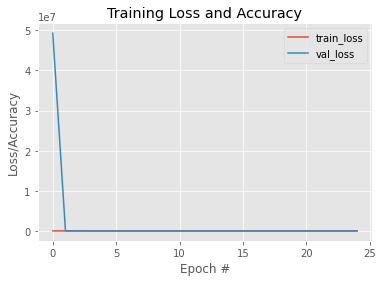

In [ ]:
# plot the training history
plot_results(H.history)

In [44]:
import os.path as osp
import glob
from utils import get_anchors, get_classes, preprocess_image
%matplotlib inline

In [ ]:
# from tensorflow.python.framework.ops import disable_eager_execution
# disable_eager_execution()

In [46]:
def show_image(image, name, contours=None):
    image = image.astype(np.uint8)
    # cv2.namedWindow(name, cv2.WINDOW_NORMAL)
    if contours is not None:
        if isinstance(contours, list):
            cv2.drawContours(image, contours, -1, (0, 0, 255), 2)
        else:
            cv2.drawContours(image, [contours], -1, (0, 0, 255), 2)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

In [45]:
# inference
model, prediction_model = yolo_body(anchors=anchors, score_threshold=0.1)
model.load_weights('/notebooks/models/yologv3_final.h5', by_name=True)
# model.load_weights('/notebooks/checkpoint/yologv3.h5', by_name=True)
BATCH_SIZE = 1
image_paths = glob.glob('/notebooks/data/test/*.jpg')
num_images = len(image_paths)
print('Number of images: {}'.format(num_images))
colors = [np.random.randint(0, 256, 3).tolist() for i in range(num_classes)]

Number of images: 6


In [47]:
# # load best weights
# model.load_weights('/notebooks/models/yologv3')

2022-12-12 03:55:54.100609: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] layout failed: INVALID_ARGUMENT: Subshape must have computed start >= end since stride is negative, but is 0 and 2 (computed from start 0 and end 9223372036854775807 over shape with rank 2 and stride-1)
2022-12-12 03:55:54.116081: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] remapper failed: INVALID_ARGUMENT: Subshape must have computed start >= end since stride is negative, but is 0 and 2 (computed from start 0 and end 9223372036854775807 over shape with rank 2 and stride-1)
2022-12-12 03:55:54.292191: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] remapper failed: INVALID_ARGUMENT: Subshape must have computed start >= end since stride is negative, but is 0 and 2 (computed from start 0 and end 9223372036854775807 over shape with rank 2 and stride-1)


400 [400] 
batch_item_num_predictions
1/1 [==============================] - 2s 2s/step


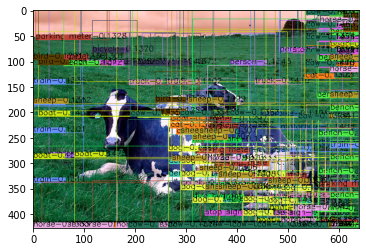

400 [400] 
batch_item_num_predictions
1/1 [==============================] - 0s 50ms/step


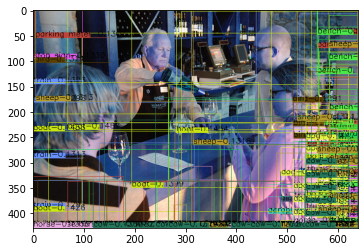

400 [400] 
batch_item_num_predictions
1/1 [==============================] - 0s 51ms/step


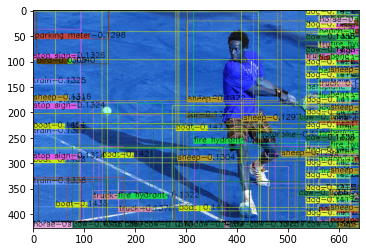

400 [400] 
batch_item_num_predictions
1/1 [==============================] - 0s 51ms/step


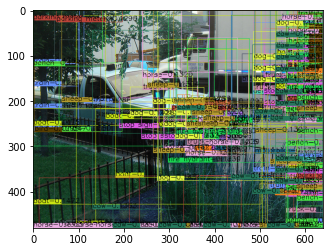

400 [400] 
batch_item_num_predictions
1/1 [==============================] - 0s 52ms/step


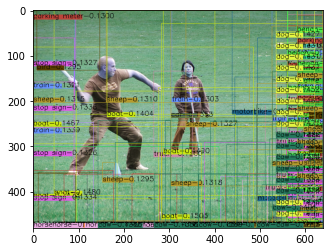

400 [400] 
batch_item_num_predictions
1/1 [==============================] - 0s 51ms/step


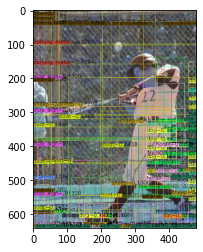

In [48]:
for i in range(0, num_images, BATCH_SIZE):
    if i + BATCH_SIZE > num_images:
        batch_image_paths = image_paths[i:]
    else:
        batch_image_paths = image_paths[i:i + BATCH_SIZE]
    batch_images_data = []
    batch_image_shapes = []
    for image_path in batch_image_paths:
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_shape = image.shape[:2]
        image_shape = np.array(image_shape)
        image_data = preprocess_image(image)
        batch_images_data.append(image_data)
        batch_image_shapes.append(image_shape)

    batch_images_data = np.array(batch_images_data)
    batch_image_shapes = np.array(batch_image_shapes)
    batch_detections = prediction_model.predict([batch_images_data, batch_image_shapes])
    for i, detections in enumerate(batch_detections):
        image_path = batch_image_paths[i]
        image = cv2.imread(image_path)
        h, w = image.shape[:2]
        detections = detections[detections[:, 4] > 0.0]
        for detection in detections:
            ymin = max(int(round(detection[0])), 0)
            xmin = max(int(round(detection[1])), 0)
            ymax = min(int(round(detection[2])), h - 1)
            xmax = min(int(round(detection[3])), w - 1)
            score = '{:.4f}'.format(detection[4])
            class_id = int(detection[5])
            color = colors[class_id - 1]
            class_name = classes[class_id]
            label = '-'.join([class_name, score])
            ret, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.3, 1)
            cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, 1)
            cv2.rectangle(image, (xmin, ymax - ret[1] - baseline), (xmin + ret[0], ymax), color, -1)
            cv2.putText(image, label, (xmin, ymax - baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)

        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        # plt.imshow(image)
        plt.show()

### Video Demo of Gaussian Yolov3 (YoloG) in Real Time